<a href="https://colab.research.google.com/github/hyewonleess/MiraeAssetContest/blob/master/Modeling_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

In [2]:
# 한글 폰트 설정
!apt -qq -y install fonts-nanum > /dev/null
 
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
 
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=10)
fm._rebuild()
 
%config InlineBackend.figure_format = 'retina'
plt.rc('font', family='NanumBarunGothic')

In [3]:
train=pd.read_csv('train.csv',header=0, encoding='utf-8')
train.head()

,ID,nur_hosp_yn,ac_ctr_diff,hsp_avg_optt_bilg_isamt_s,hsp_avg_surop_bilg_isamt_s,ar_rclss_cd,fds_cust_yn,hspz_dys_s,inamt_nvcd,hsp_avg_diag_bilg_isamt_s,blrs_cd,dsas_ltwt_gcd,dsas_avg_diag_bilg_isamt_s,dsas_acd_rst_dcd,base_ym,kcd_gcd,hsp_avg_hspz_bilg_isamt_s,optt_blcnt_s,mtad_cntr_yn,heltp_pf_ntyn,prm_nvcd,surop_blcnt_s,mdct_inu_rclss_dcd,dsas_avg_optt_bilg_isamt_s,isrd_age_dcd,hspz_blcnt_s,dsas_avg_surop_bilg_isamt_s,urlb_fc_yn,dsas_avg_hspz_bilg_isamt_s,smrtg_5y_passed_yn,ac_rst_diff,bilg_isamt_s,optt_nbtm_s,target
0,0,0,6,0.1303,0.0000,1,0,0.3452,4,0.0000,12,1,0.9793,1,201901,3,1.6021,2.0,0,0,1,0.0,2,1.2002,3,10.0000,1.1701,0,1.2612,0,0,0.4240,0.8571,1
1,1,1,6,0.0000,0.5770,4,0,0.0000,4,0.0000,2,3,0.0000,22,201901,8,0.0000,0.0,0,0,1,1.0,1,0.0000,4,0.0000,0.1508,0,0.0023,0,0,0.8602,0.0000,0
2,2,1,6,0.0000,0.2885,1,1,0.0000,6,0.0000,2,3,0.0000,22,201901,8,0.0000,0.0,0,0,1,1.0,1,0.0000,4,0.0000,0.1508,0,0.0023,0,0,0.4301,0.0000,1
3,3,0,4,0.0197,0.0680,2,0,0.8056,6,0.0587,8,3,0.0000,23,201901,8,0.5638,0.0,0,0,1,0.0,2,0.0000,9,1.4444,0.0863,0,0.1920,0,0,0.2509,0.0000,1
4,4,0,5,0.0000,0.0000,9,0,0.4167,2,0.0000,8,3,0.0000,23,201901,8,0.4464,0.0,0,0,2,0.0,2,0.0000,0,1.3333,0.0863,0,0.1920,0,0,0.0323,0.0000,1


In [4]:
variable = ['ID','base_ym','dsas_ltwt_gcd','kcd_gcd','dsas_acd_rst_dcd','ar_rclss_cd','blrs_cd','mdct_inu_rclss_dcd','nur_hosp_yn','optt_nbtm_s','bilg_isamt_s','hspz_dys_s','hsp_avg_hspz_bilg_isamt_s','hsp_avg_optt_bilg_isamt_s',
            'hsp_avg_surop_bilg_isamt_s','hsp_avg_diag_bilg_isamt_s','dsas_avg_hspz_bilg_isamt_s','dsas_avg_optt_bilg_isamt_s','dsas_avg_surop_bilg_isamt_s','dsas_avg_diag_bilg_isamt_s','hspz_blcnt_s','surop_blcnt_s','optt_blcnt_s',
            'isrd_age_dcd','fds_cust_yn','smrtg_5y_passed_yn','mtad_cntr_yn','heltp_pf_ntyn','prm_nvcd','inamt_nvcd','ac_ctr_diff','ac_rst_diff','urlb_fc_yn','target']
variable_kor = ['접수일련번호','접수년월','질병경중등급코드','KCD등급코드','질병구분코드','발생지역구분코드','치료행위코드','의료기관구분코드','요양병원여부','통원횟수','청구보험금','입원일수','병원별평균입원청구보험금',
                '병원별평균통원청구보험금','병원별평균수술청구보험금','병원별평균진단청구보험금','질병별평균입원청구보험금','질병별평균통원청구보험금','질병별평균수술청구보험금','질병별평균진단청구보험금','입원청구건수',
                '수술청구건수','통원청구건수','고객나이구분코드','보험사기이력고객여부','부담보5년경과여부','중도부가계약여부','건강인우대계약여부','보험료구간코드','가입금액구간코드','청구일계약일간기간구분코드',
                '청구일부활일간기간구분코드','부실판매자계약여부','실사상태코드']

In [5]:
train = train[variable]
df = train.copy()
df.columns = variable_kor
df.head()

,접수일련번호,접수년월,질병경중등급코드,KCD등급코드,질병구분코드,발생지역구분코드,치료행위코드,의료기관구분코드,요양병원여부,통원횟수,청구보험금,입원일수,병원별평균입원청구보험금,병원별평균통원청구보험금,병원별평균수술청구보험금,병원별평균진단청구보험금,질병별평균입원청구보험금,질병별평균통원청구보험금,질병별평균수술청구보험금,질병별평균진단청구보험금,입원청구건수,수술청구건수,통원청구건수,고객나이구분코드,보험사기이력고객여부,부담보5년경과여부,중도부가계약여부,건강인우대계약여부,보험료구간코드,가입금액구간코드,청구일계약일간기간구분코드,청구일부활일간기간구분코드,부실판매자계약여부,실사상태코드
0,0,201901,1,3,1,1,12,2,0,0.8571,0.4240,0.3452,1.6021,0.1303,0.0000,0.0000,1.2612,1.2002,1.1701,0.9793,10.0000,0.0,2.0,3,0,0,0,0,1,4,6,0,0,1
1,1,201901,3,8,22,4,2,1,1,0.0000,0.8602,0.0000,0.0000,0.0000,0.5770,0.0000,0.0023,0.0000,0.1508,0.0000,0.0000,1.0,0.0,4,0,0,0,0,1,4,6,0,0,0
2,2,201901,3,8,22,1,2,1,1,0.0000,0.4301,0.0000,0.0000,0.0000,0.2885,0.0000,0.0023,0.0000,0.1508,0.0000,0.0000,1.0,0.0,4,1,0,0,0,1,6,6,0,0,1
3,3,201901,3,8,23,2,8,2,0,0.0000,0.2509,0.8056,0.5638,0.0197,0.0680,0.0587,0.1920,0.0000,0.0863,0.0000,1.4444,0.0,0.0,9,0,0,0,0,1,6,4,0,0,1
4,4,201901,3,8,23,9,8,2,0,0.0000,0.0323,0.4167,0.4464,0.0000,0.0000,0.0000,0.1920,0.0000,0.0863,0.0000,1.3333,0.0,0.0,0,0,0,0,0,2,2,5,0,0,1


In [6]:
df.isnull().sum()

접수일련번호           0
접수년월             0
질병경중등급코드         0
KCD등급코드          0
질병구분코드           0
발생지역구분코드         0
치료행위코드           0
의료기관구분코드         0
요양병원여부           0
통원횟수             0
청구보험금            0
입원일수             0
병원별평균입원청구보험금     0
병원별평균통원청구보험금     0
병원별평균수술청구보험금     0
병원별평균진단청구보험금     0
질병별평균입원청구보험금     0
질병별평균통원청구보험금     0
질병별평균수술청구보험금     0
질병별평균진단청구보험금     0
입원청구건수           0
수술청구건수           0
통원청구건수           0
고객나이구분코드         0
보험사기이력고객여부       0
부담보5년경과여부        0
중도부가계약여부         0
건강인우대계약여부        0
보험료구간코드          0
가입금액구간코드         0
청구일계약일간기간구분코드    0
청구일부활일간기간구분코드    0
부실판매자계약여부        0
실사상태코드           0
dtype: int64

## 1. Feature 선택

+ 제거할 변수: `접수일련번호`, `접수년월`, `발생지역구분코드`

In [7]:
id_=['접수일련번호','접수년월','실사상태코드'] 

# 고객정보
customer_order='고객나이구분코드' # 체크
customer_bool='보험사기이력고객여부' 
# 상품정보
products_bool=['부담보5년경과여부','중도부가계약여부','건강인우대계약여부']
products_order=['보험료구간코드','가입금액구간코드','청구일계약일간기간구분코드','청구일부활일간기간구분코드']
# 판매자정보
seller='부실판매자계약여부'
# 질병정보
disease_bool='요양병원여부'
disease_order=['질병경중등급코드','KCD등급코드','질병구분코드','발생지역구분코드','치료행위코드','의료기관구분코드']
disease_conti=[x for x in df.columns if (x.endswith('보험금') or x.endswith('수'))]

### (1) `보험료구간코드`, `가입금액구간코드` 
+ Unknown variable 특징: target 분포가 다른 카테고리와 양상이 많이 다름 - 조사(2) 의 비율이 가장 높음

In [8]:
# 보험료구간코드 99인 데이터를 제거하면 두 변수의 상관관계가 낮아진다.
df.loc[df['보험료구간코드']!=99,['보험료구간코드','가입금액구간코드']].corr()

,보험료구간코드,가입금액구간코드
보험료구간코드,1.000000,0.152574
가입금액구간코드,0.152574,1.000000


In [9]:
df_99=df[df['보험료구간코드']==99]
df_99.shape

(34436, 34)

 + `고객나이구분코드` 에서 문제가 되는 카테고리 7, 9 중 7을 df_99 가 거의 대부분 차지했다 --> `고객나이구분코드` 7 이 Unknown 값이라고 예상됨

Text(0.5, 1.0, '보험료구간코드 99 데이터 vs 원본데이터 고객연령대분포')

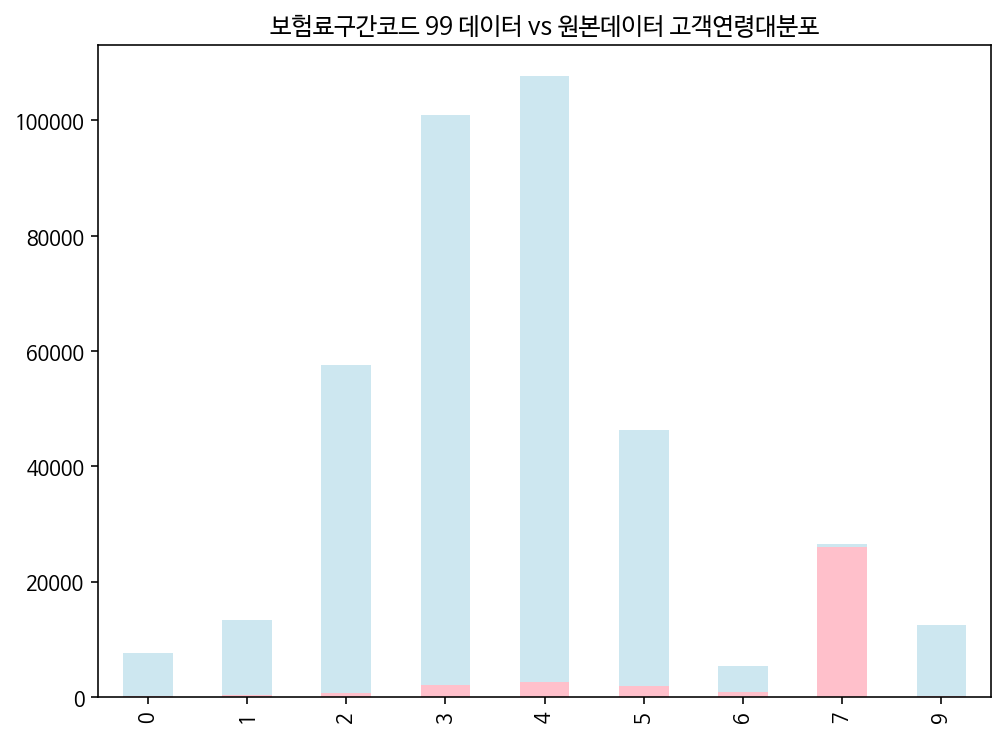

In [10]:
df[customer_order].value_counts().sort_index().plot.bar(color='lightblue',figsize=(8,6),alpha=0.6)
df_99[customer_order].value_counts().sort_index().plot.bar(color='pink',figsize=(8,6))
plt.title('보험료구간코드 99 데이터 vs 원본데이터 고객연령대분포')

In [11]:
# 타겟별 변수 count stacking 함수
def bar_stack_target(df,x_var):
  group=df.groupby([x_var,'실사상태코드'])['부실판매자계약여부'].count()
  group=group/group.groupby(level=0).sum()
  group=group.reset_index().rename(columns={'부실판매자계약여부':'비율'})

  sns.barplot(data=group,x=x_var,y='비율',hue='실사상태코드',palette='coolwarm')
  plt.title(f'{x_var}별 실사상태코드 분포',fontsize=15); plt.ylabel('비율(%)')
  plt.show()

#### df_99 vs df (original data)

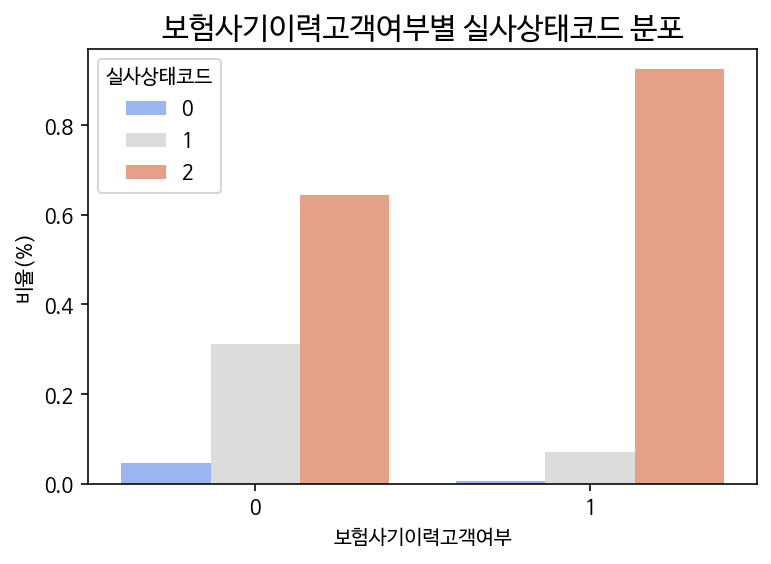

In [12]:
bar_stack_target(df_99,'보험사기이력고객여부')

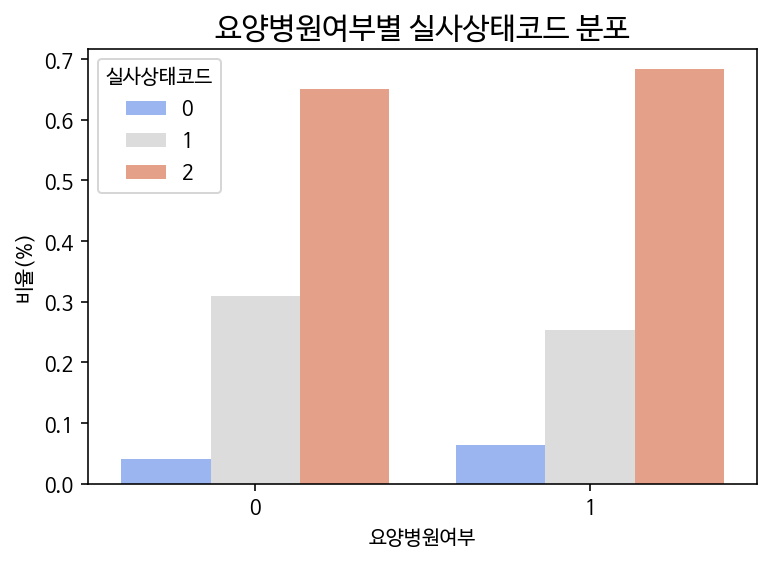

In [13]:
bar_stack_target(df_99,'요양병원여부')

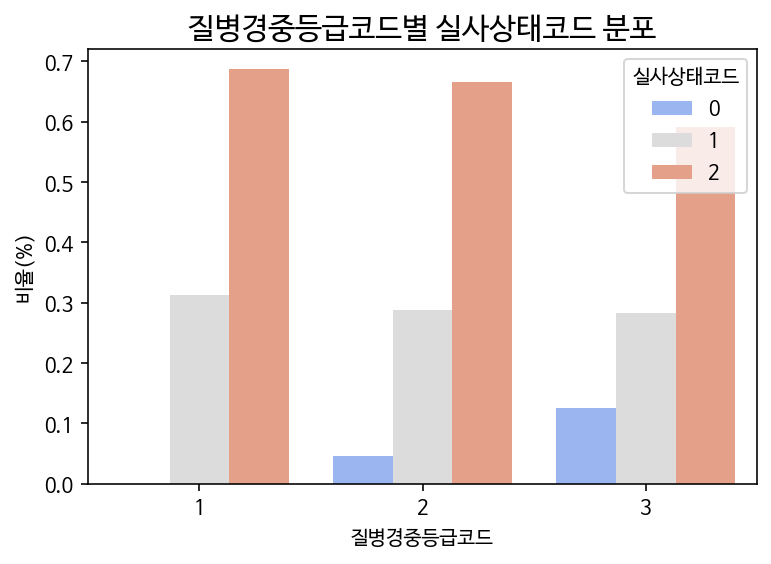

In [14]:
bar_stack_target(df_99,'질병경중등급코드')

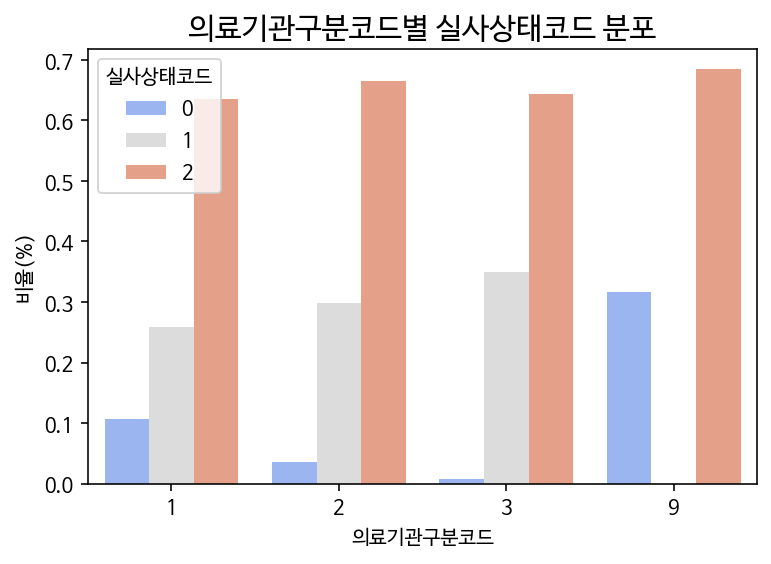

In [15]:
bar_stack_target(df_99,'의료기관구분코드')

**결론** <br>
+ `보험료구간코드` 99 (Unkown) 데이터는 전체 데이터의 9%나 차지하기 때문에 제거는 하지 않는다. 
+ 이 데이터들의 target 분포 양상이 Original data 와 매우 다르기때문에(조사(2)의 비율이 대체로 높음), 다른 카테고리 데이터 (보험료구간코드 0,1,2,3,4,..) 와 결합하는 것은 적절하지 않은 것 같다.
+ Solution) 새로운 변수 만들기 - 새로운 카테고리형 변수를 생성하여 보험료구간코드가 99이면 1, 아니면 0으로 표시

### (2) `고객나이구분코드`
+ 카테고리 7: Unkown 데이터인 것으로 예상됨
+ 카테고리 9: 다른 연령대보다 자동지급(0) 의 비율이 높은 편이다. 타겟분포 양상은 카테고리 0 이나 1과 비슷

In [16]:
df[customer_order].value_counts().sort_index()

0      7550
1     13344
2     57563
3    100922
4    107780
5     46338
6      5395
7     26577
9     12459
Name: 고객나이구분코드, dtype: int64

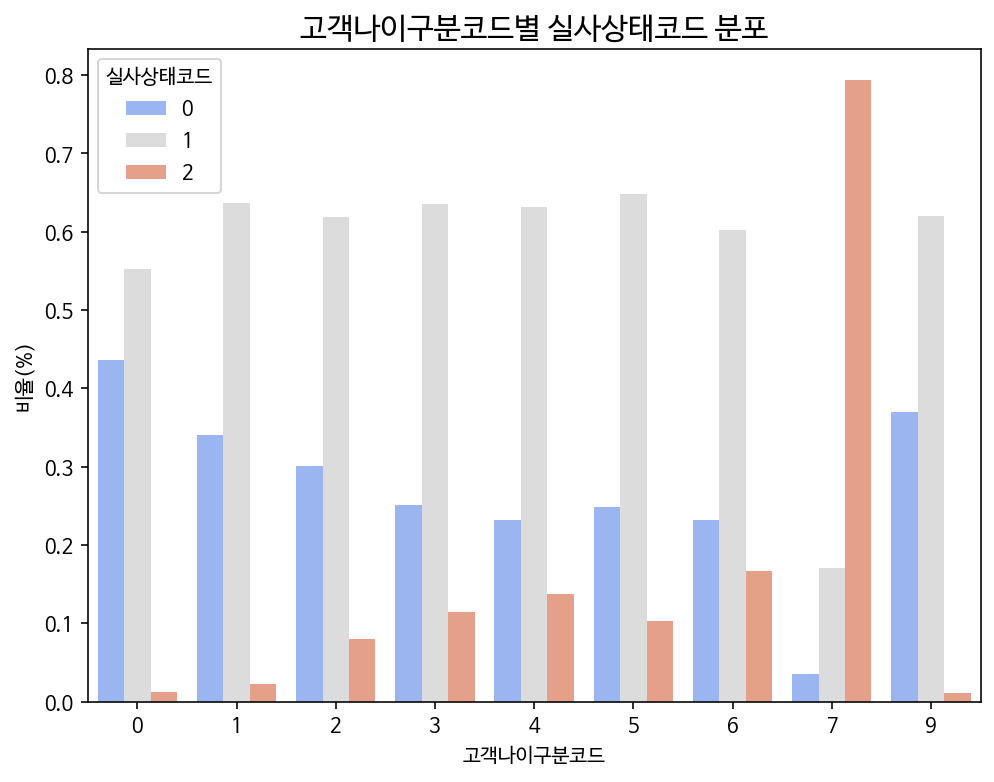

In [17]:
plt.figure(figsize=(8,6))
bar_stack_target(df,'고객나이구분코드')

In [18]:
df_age_9=df[df['고객나이구분코드']==9]
df_age_9.shape

(12459, 34)

#### Hierarchical Clustering - 고객나이구분코드 클러스터링

In [19]:
data=df.drop(['접수일련번호','접수년월','발생지역구분코드'],axis=1)
data=data.groupby(['고객나이구분코드']).mean()

In [20]:
data.index

Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 9], dtype='int64', name='고객나이구분코드')

In [21]:
from sklearn.preprocessing import normalize

In [22]:
# normalize data for clustering
data_scaled=normalize(data)
data_scaled=pd.DataFrame(data_scaled, columns=data.columns)
data_scaled.head(3)

,질병경중등급코드,KCD등급코드,질병구분코드,치료행위코드,의료기관구분코드,요양병원여부,통원횟수,청구보험금,입원일수,병원별평균입원청구보험금,병원별평균통원청구보험금,병원별평균수술청구보험금,병원별평균진단청구보험금,질병별평균입원청구보험금,질병별평균통원청구보험금,질병별평균수술청구보험금,질병별평균진단청구보험금,입원청구건수,수술청구건수,통원청구건수,보험사기이력고객여부,부담보5년경과여부,중도부가계약여부,건강인우대계약여부,보험료구간코드,가입금액구간코드,청구일계약일간기간구분코드,청구일부활일간기간구분코드,부실판매자계약여부,실사상태코드
0,0.106930,0.432859,0.742891,0.359489,0.085290,0.002734,0.001492,0.023794,0.025752,0.034145,0.018495,0.022968,0.015118,0.014608,0.003189,0.009552,0.002573,0.033205,0.019437,0.001097,0.000436,0.000011,0.000034,0.000000,0.100712,0.207504,0.231584,0.006768,0.000315,0.024911
1,0.104214,0.361656,0.783132,0.311303,0.081544,0.006454,0.010531,0.052851,0.019262,0.034455,0.025870,0.031740,0.018742,0.017236,0.009369,0.015602,0.008127,0.029082,0.031156,0.002243,0.000320,0.000059,0.000071,0.000003,0.126536,0.246522,0.233621,0.016710,0.000422,0.028279
2,0.105987,0.353167,0.767905,0.322429,0.090450,0.009336,0.019535,0.086323,0.025916,0.045970,0.032582,0.037547,0.021219,0.023906,0.015518,0.022605,0.015028,0.034287,0.035972,0.003431,0.000361,0.000033,0.000214,0.000116,0.109102,0.244469,0.266245,0.026666,0.000294,0.036023


In [23]:
import scipy.cluster.hierarchy as shc

**Dendrogram 해석** 
 + 카테고리 7은 우리가 Unknown variable 로 예측했듯이, dendrogram 상에서 다른 카테고리와 함께 클러스터링 되지 않았다.
 + 그리고 그 속성이 밝혀지지 않았던 카테고리 9는 dendrogram 을 보면 카테고리 0과 가장 먼저 클러스터링이 된다. -> 카테고리 9 데이터를  카테고리 0 (나이대 0s) 데이터과 결합해도 될듯? 하다

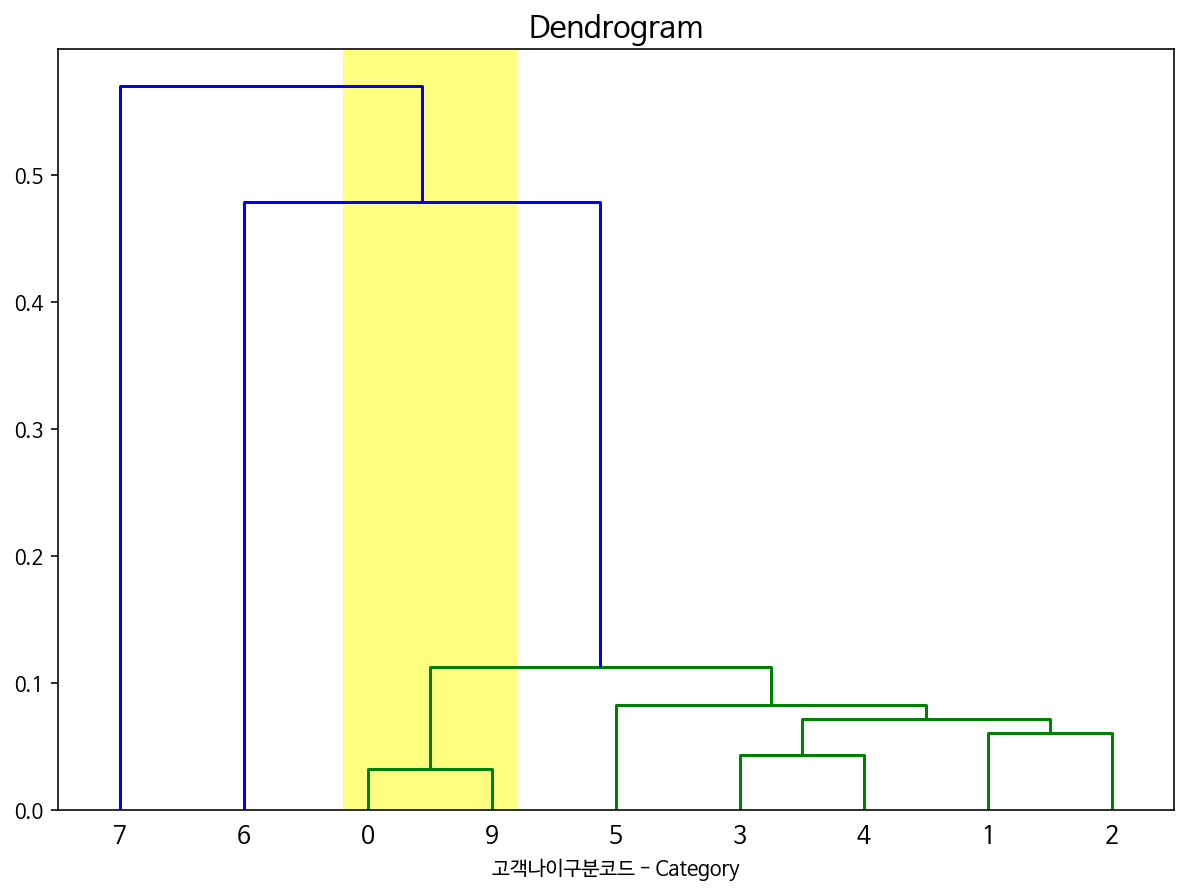

In [24]:
plt.figure(figsize=(10,7))
plt.title('Dendrogram',fontsize=15)
dend=shc.dendrogram(shc.linkage(data_scaled,method='single'), labels=[0,1,2,3,4,5,6,7,9])
plt.xlabel('고객나이구분코드 - Category')
plt.axvspan(23,37, facecolor='yellow', alpha=0.5)

### (3) `질병구분코드` & `KCD등급코드`

In [25]:
dgroup=df.groupby(['KCD등급코드','질병구분코드'])['접수년월'].count().reset_index().rename(columns={'접수년월': 'Count'})

In [26]:
disease_group=df.groupby(['KCD등급코드','질병구분코드'])['접수년월'].count()
disease_group=disease_group/disease_group.groupby(level=0).sum()
disease_group=disease_group.reset_index().rename(columns={'접수년월':'비율'})
disease_group

,KCD등급코드,질병구분코드,비율
0,2,1,0.004052
1,2,2,0.001216
2,2,3,0.000405
3,2,4,0.001621
4,2,5,0.005673
...,...,...,...
199,13,27,0.000023
200,14,9,0.075404
201,14,25,0.099501
202,14,26,0.382892


In [27]:
disease_group['Count']=dgroup['Count'].values
disease_group

,KCD등급코드,질병구분코드,비율,Count
0,2,1,0.004052,10
1,2,2,0.001216,3
2,2,3,0.000405,1
3,2,4,0.001621,4
4,2,5,0.005673,14
...,...,...,...,...
199,13,27,0.000023,1
200,14,9,0.075404,3608
201,14,25,0.099501,4761
202,14,26,0.382892,18321


In [28]:
# 기준: 각 그룹에서 70% 이상 차지
d_main=disease_group[disease_group['비율']>0.7]
d_main

,KCD등급코드,질병구분코드,비율,Count
6,2,7,0.982577,2425
7,3,1,0.987781,89004
24,4,28,0.891733,66188
37,5,16,0.765269,9673
101,8,22,0.916916,31508
132,10,11,0.820807,16371
189,13,17,0.963814,41630


**결론**
 + `질병경중등급코드` 와 `질병구분코드` 상관관계가 높음 --> 둘 중 하나 제거?
 + `질병구분코드` 와 `KCD등급코드`를 그룹화하고 각 질병구분코드 그룹에서 가장 차지하는 비율이 높은 KCD등급코드를 뽑았을 때, 대체로 잘 분류된 것을 확인할 수 있다. --> 이제 나머지 잘못 분류된(?) 자료들을 제거해야할지 아니면 남겨둘지 정해야할듯!

### (4) 평균청구보험금

**Correlation 살펴보기**

In [29]:
corr_mat=df[disease_order+disease_conti].corr()
upper=corr_mat.where(np.triu(np.ones(corr_mat.shape),k=1).astype(np.bool))
to_drop=[col for col in upper.columns if any(abs(upper[col])>0.6)]
to_drop

['질병구분코드',
 '병원별평균진단청구보험금',
 '질병별평균입원청구보험금',
 '질병별평균통원청구보험금',
 '질병별평균수술청구보험금',
 '질병별평균진단청구보험금']

**해석**
 + `질병경중등급코드`(or `질병구분코드`) - `질병별평균~청구보험금` 4 변수의 음의 상관관계가 매우 높다.
  

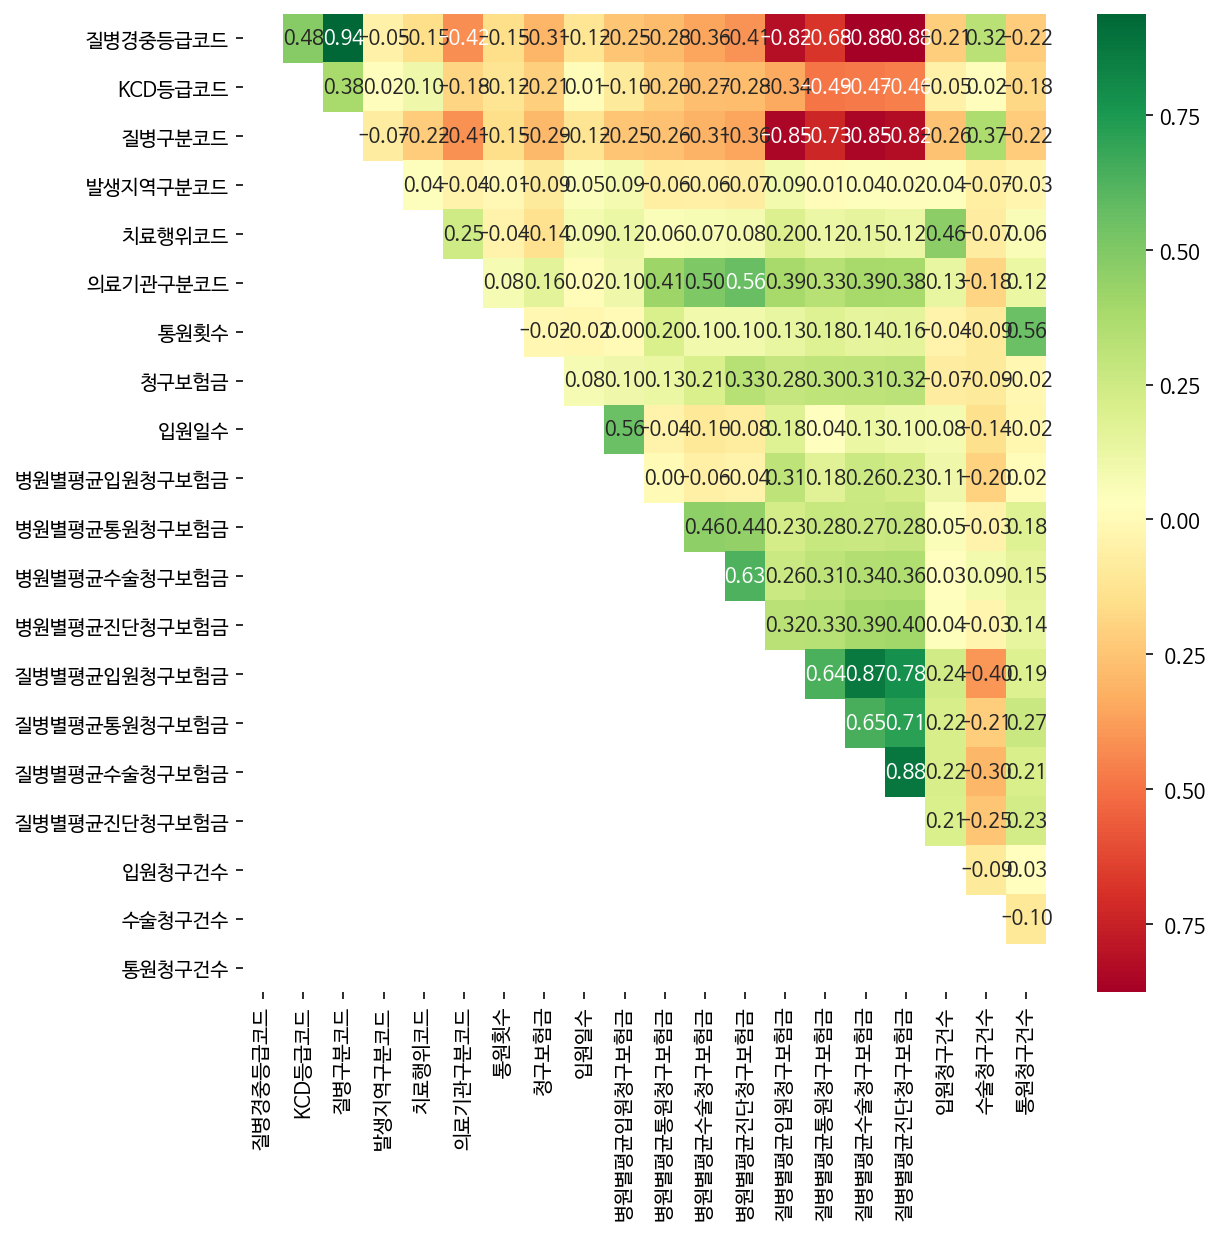

In [30]:
mask=np.zeros_like(corr_mat, dtype=np.bool)
mask[np.tril_indices_from(mask)]=True

plt.figure(figsize=(9,9))
sns.heatmap(corr_mat, mask=mask, cmap='RdYlGn',annot=True, fmt='.2f')

#### 병원별평균~청구보험금
 + `병원별청구보험금` 변수들 모두 0 값의 비율이 각각 24%, 56%, 9.4%, 62% 로 매우 높게 나타난다. 
 + `질병별평균청구보험금` 변수들 중 `질병별평균통원청구보험금` 과 `질병별평균진단청구보험금` 의 0 값 비율이 매우 높다.

In [31]:
for col in ['병원별평균입원청구보험금','병원별평균통원청구보험금','병원별평균수술청구보험금','병원별평균진단청구보험금']:
  num_0=np.round(len(df[df[col]==0])/len(df),3)*100
  print(f'{col} 변수 0 값 비율: {num_0} %')

병원별평균입원청구보험금 변수 0 값 비율: 15.1 %
병원별평균통원청구보험금 변수 0 값 비율: 44.6 %
병원별평균수술청구보험금 변수 0 값 비율: 11.600000000000001 %
병원별평균진단청구보험금 변수 0 값 비율: 50.5 %


`질병통원청구보험금`, `질병진단청구보험금`, `병원별통원청구보험금`, `병원별진단청구보험금` 은 Unkown variable 비율이 매우 높으므로 제거하는 것이 좋을 것 같다.

In [32]:
for col in ['질병별평균입원청구보험금','질병별평균통원청구보험금','질병별평균수술청구보험금','질병별평균진단청구보험금']:
  num_0=np.round(len(df[df[col]==0])/len(df),3)*100
  print(f'{col} 변수 0 값 비율: {num_0} %')

질병별평균입원청구보험금 변수 0 값 비율: 0.0 %
질병별평균통원청구보험금 변수 0 값 비율: 59.4 %
질병별평균수술청구보험금 변수 0 값 비율: 1.0 %
질병별평균진단청구보험금 변수 0 값 비율: 64.0 %


In [33]:
df[disease_conti].describe()

,통원횟수,청구보험금,입원일수,병원별평균입원청구보험금,병원별평균통원청구보험금,병원별평균수술청구보험금,병원별평균진단청구보험금,질병별평균입원청구보험금,질병별평균통원청구보험금,질병별평균수술청구보험금,질병별평균진단청구보험금,입원청구건수,수술청구건수,통원청구건수
count,377928.000000,377928.000000,377928.000000,377928.000000,377928.000000,377928.000000,377928.000000,377928.000000,377928.000000,377928.000000,377928.000000,377928.000000,377928.000000,377928.000000
mean,0.279641,1.752007,0.974648,1.201778,0.617748,0.724437,0.402857,0.584304,0.335058,0.529102,0.353262,0.755198,0.751618,0.048891
std,2.391219,5.641433,4.841651,2.705497,1.353445,0.741922,0.535260,0.502351,0.501107,0.484076,0.505435,1.055823,0.782821,0.258888
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001400,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.176800,0.000000,0.282200,0.000000,0.223100,0.000000,0.125600,0.000000,0.141900,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.385700,0.208300,0.804400,0.041700,0.445900,0.000000,0.522100,0.000000,0.167100,0.000000,0.666700,1.000000,0.000000
75%,0.000000,0.918625,0.897200,1.240100,0.712400,1.138700,0.856100,1.049900,0.765100,1.123600,0.972300,0.953300,1.000000,0.000000
max,90.000000,107.526900,417.083300,142.687000,66.486500,13.704100,5.647200,2.034400,2.237500,2.440600,2.948900,35.333300,21.666700,7.000000


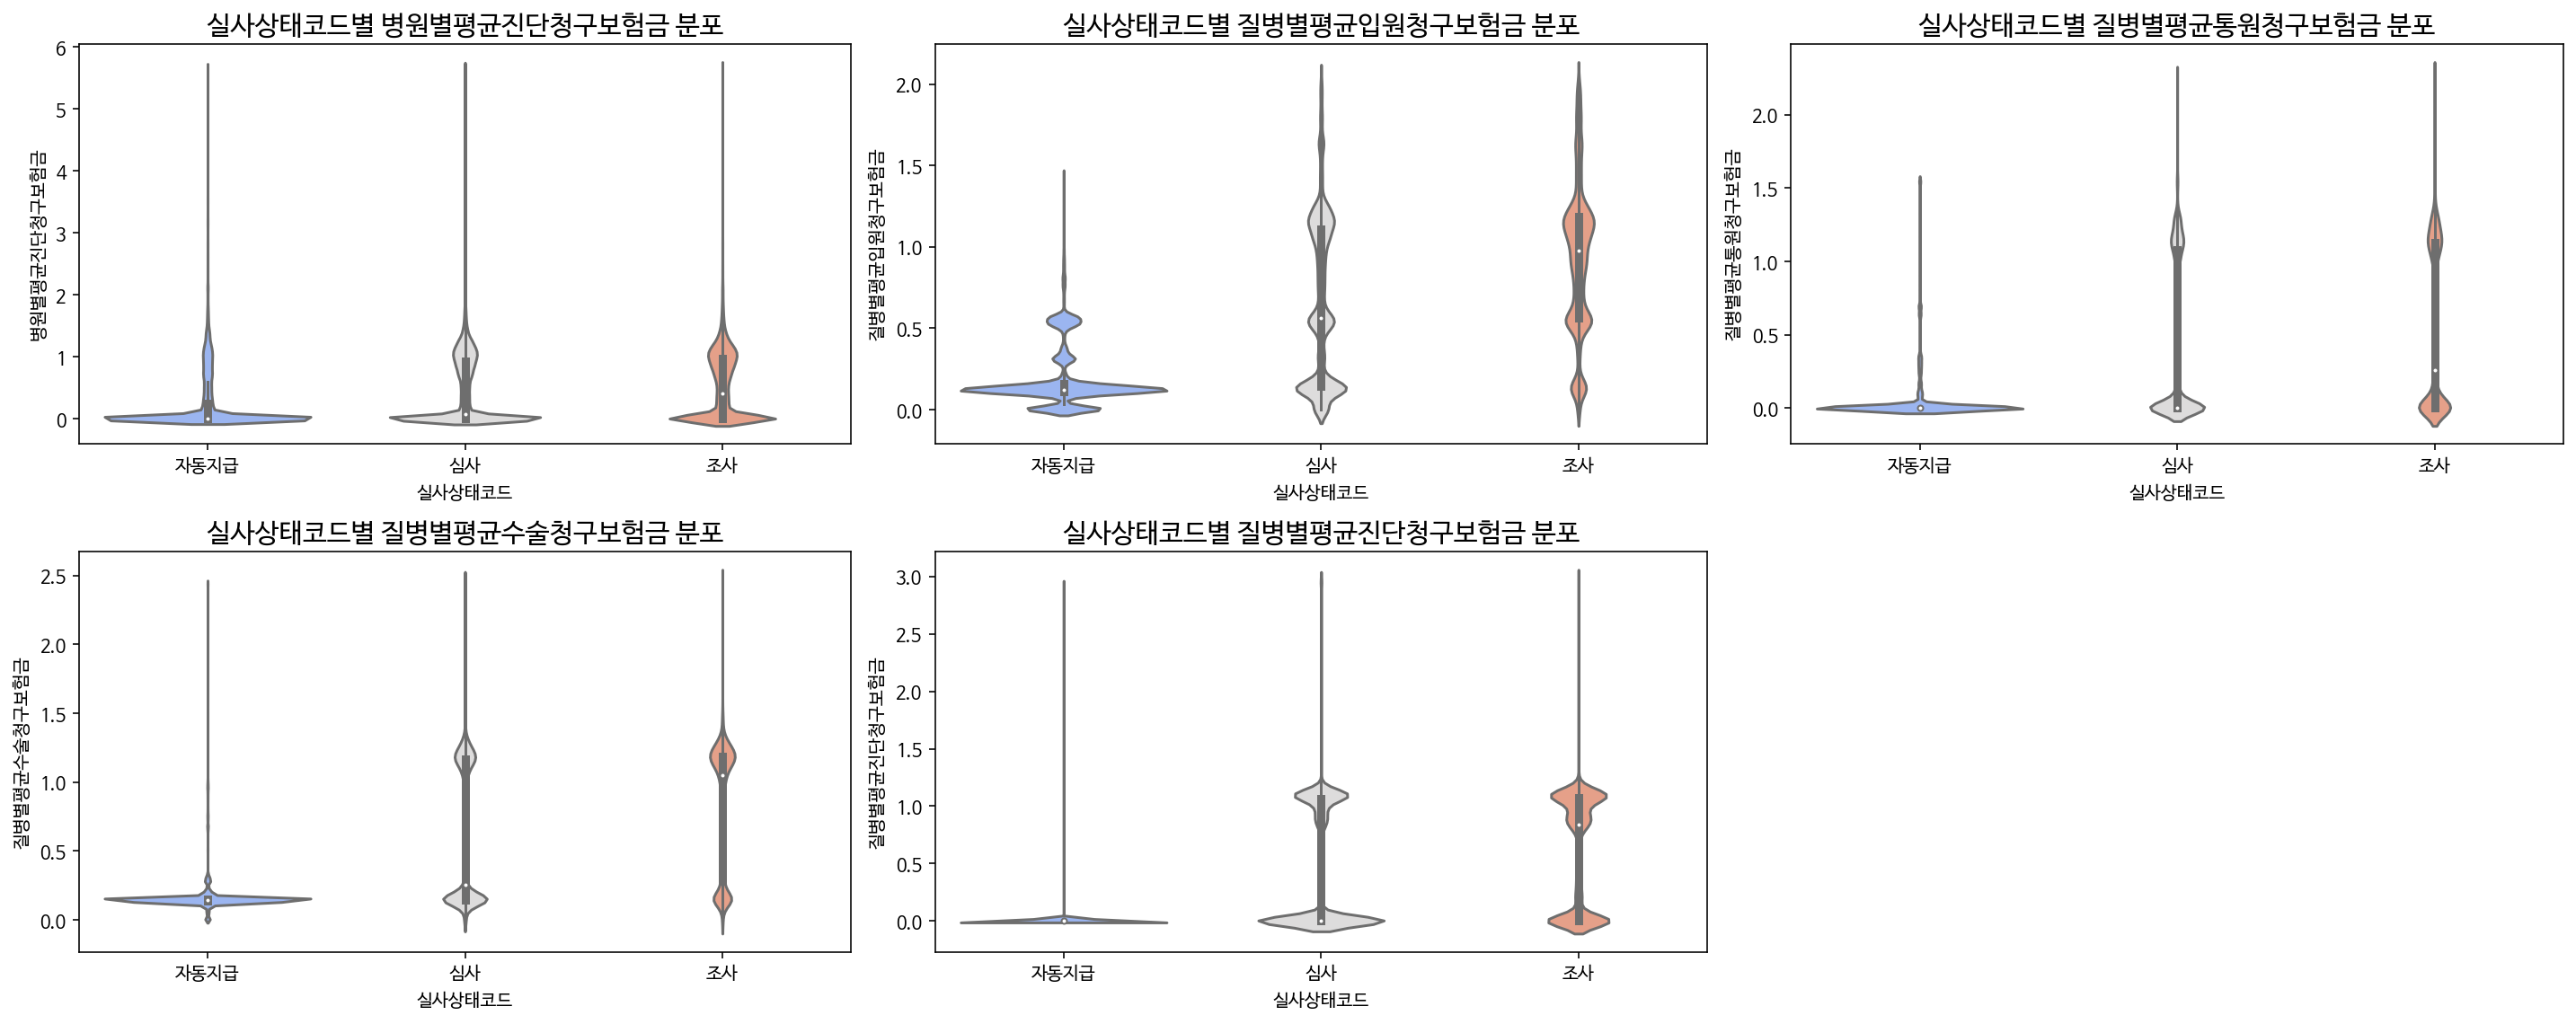

In [34]:
plt.figure(figsize=(20,8))
for i, col in enumerate(to_drop[1:]):
  ax=plt.subplot(2,3,i+1)
  sns.violinplot(data=df, x='실사상태코드', y=col, palette='coolwarm', ax=ax)
  plt.title(f'실사상태코드별 {col} 분포',fontsize=15); plt.xticks([0,1,2],['자동지급','심사','조사'])
plt.tight_layout()
plt.show()

## 2. Feature Engineering

In [35]:
# 보험료구간코드, 가입금액구간코드 Unkown variable 처리 (고객나이구분코드 7도 어느정도 처리됨) - 수정필요!
def get_99_col(df,col):
  data99=[]
  for value in df[col].values:
    if value==99:
      data99.append(1)
    else:
      data99.append(0)
  return data99

In [36]:
def get_features_target(df):
  df.drop(['접수일련번호','접수년월','발생지역구분코드'],axis=1,inplace=True)
  df.drop(['질병구분코드','병원별평균진단청구보험금','질병별평균통원청구보험금','질병별평균진단청구보험금'],axis=1,inplace=True)
  df['보험료구간99여부']=get_99_col(df,'보험료구간코드')
  df=df[df['의료기관구분코드']!=9]
  df['고객나이구분코드'].replace(9,0,inplace=True)
  features=df.drop(['실사상태코드'],axis=1)
  target=df['실사상태코드']
  return features, target

In [38]:
features, target= get_features_target(df)
print(features.head())
print(target)

   질병경중등급코드  KCD등급코드  치료행위코드  ...  청구일부활일간기간구분코드  부실판매자계약여부  보험료구간99여부
0         1        3      12  ...              0          0          0
1         3        8       2  ...              0          0          0
2         3        8       2  ...              0          0          0
3         3        8       8  ...              0          0          0
4         3        8       8  ...              0          0          0

[5 rows x 27 columns]
0         1
1         0
2         1
3         1
4         1
         ..
377923    2
377924    2
377925    2
377926    2
377927    2
Name: 실사상태코드, Length: 377735, dtype: int64


**논의 필요**

In [37]:
# 6. 치료행위코드- '질병 진단' 이라는 항목이 포함되면 타겟에서 조사(2)의 비율이 높게 나타나는 것을 확인했었음
#df['질병진단여부']=0
#df.loc[df['치료행위코드'].isin([1,3,5,7,9,11,13,15]),'질병진단여부']=1 
#df.head()

## 3. Modeling

### (1) RandomForest - Oversampling

In [41]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val=train_test_split(features, target, random_state=0, test_size=0.2) # Target data 불균형
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(302188, 27)
(75547, 27)
(302188,)
(75547,)


**SMOTE Oversampling - imbalanced target**

In [43]:
from imblearn.over_sampling import SMOTE

In [44]:
smote=SMOTE(random_state=0)
X_train_over, y_train_over=smote.fit_sample(X_train,y_train)
print('SMOTE 적용 전 train dataset: ', X_train.shape, y_train.shape)
print('SMOTE 적용 후 train dataset: ', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블값 분포: \n ', pd.Series(y_train_over).value_counts())

SMOTE 적용 전 train dataset:  (302188, 27) (302188,)
SMOTE 적용 후 train dataset:  (542487, 27) (542487,)
SMOTE 적용 후 레이블값 분포: 
  2    180829
1    180829
0    180829
dtype: int64


In [45]:
# RandomForest
rf=RandomForestClassifier(n_estimators=100, random_state=0)
rf.fit(X_train,y_train)
pred=rf.predict(X_val)
f1score=f1_score(y_val,pred,average='macro')
f1score

0.9418669842303037

In [69]:
# LGBM
lgbm=LGBMClassifier(n_estimators=1000, random_state=0, num_leaves=32, boost_from_average=False)
lgbm.fit(X_train,y_train)
pred=lgbm.predict(X_val)
f1score=f1_score(y_val,pred,average='macro')
f1score

0.8653131346694717

### (2) Stratified KFold 

In [ ]:
# RandomForestClassifier
rf=RandomForestClassifier(n_estimators=100, random_state=0, verbose=0)

skfold=StratifiedKFold(n_splits=5)
n_iter=0
cv_f1score=[]

for train_idx, val_idx in skfold.split(features, target):
  X_train, X_val= features.iloc[train_idx,:], features.iloc[val_idx,:]
  y_train,y_val= target.iloc[train_idx], target.iloc[val_idx]
  rf.fit(X_train,y_train)
  pred=rf.predict(X_val)
  
  n_iter+=1
  f1score=np.round(f1_score(y_val,pred,average='macro'),3)
  cv_f1score.append(f1score)
print('교차검증별 F1 Score: ', cv_f1score)
print('평균 교차검증 F1 Score: ',np.mean(cv_f1score))

교차검증별 F1 Score:  [0.939, 0.944, 0.945, 0.945, 0.945]
평균 교차검증 F1 Score:  0.9436


In [72]:
# LGBMClassifier
lgbm=LGBMClassifier(n_estimators=1000, random_state=0, num_leaves=32, boost_from_average=False)

skfold=StratifiedKFold(n_splits=5)
n_iter=0
cv_f1score=[]

for train_idx, val_idx in skfold.split(features, target):
  X_train, X_val= features.iloc[train_idx,:], features.iloc[val_idx,:]
  y_train,y_val= target.iloc[train_idx], target.iloc[val_idx]
  lgbm.fit(X_train,y_train)
  pred=rf.predict(X_val)
  
  n_iter+=1
  f1score=np.round(f1_score(y_val,pred,average='macro'),3)
  cv_f1score.append(f1score)
print('교차검증별 F1 Score: ', cv_f1score)
print('평균 교차검증 F1 Score: ',np.mean(cv_f1score))

교차검증별 F1 Score:  [0.985, 0.988, 0.989, 0.989, 0.989]
평균 교차검증 F1 Score:  0.9879999999999999


**Feature Importance 추출**

In [ ]:
feature_names=features.columns
feature_imp=pd.DataFrame(rf.feature_importances_,index=feature_names).rename(columns={0:'importance'}).sort_values(by='importance',ascending=False)
feature_imp

### Test

In [54]:
test=pd.read_csv('test.csv', header=0, encoding='utf-8')
sample=pd.read_csv('sample.csv', header=0, encoding='utf-8')

In [57]:
def data_test(test):
  # 변수명 한글로 변환
  variable = ['ID','base_ym','dsas_ltwt_gcd','kcd_gcd','dsas_acd_rst_dcd','ar_rclss_cd','blrs_cd','mdct_inu_rclss_dcd','nur_hosp_yn','optt_nbtm_s','bilg_isamt_s','hspz_dys_s','hsp_avg_hspz_bilg_isamt_s','hsp_avg_optt_bilg_isamt_s',
            'hsp_avg_surop_bilg_isamt_s','hsp_avg_diag_bilg_isamt_s','dsas_avg_hspz_bilg_isamt_s','dsas_avg_optt_bilg_isamt_s','dsas_avg_surop_bilg_isamt_s','dsas_avg_diag_bilg_isamt_s','hspz_blcnt_s','surop_blcnt_s','optt_blcnt_s',
            'isrd_age_dcd','fds_cust_yn','smrtg_5y_passed_yn','mtad_cntr_yn','heltp_pf_ntyn','prm_nvcd','inamt_nvcd','ac_ctr_diff','ac_rst_diff','urlb_fc_yn']
  variable_kor = ['접수일련번호','접수년월','질병경중등급코드','KCD등급코드','질병구분코드','발생지역구분코드','치료행위코드','의료기관구분코드','요양병원여부','통원횟수','청구보험금','입원일수','병원별평균입원청구보험금',
                '병원별평균통원청구보험금','병원별평균수술청구보험금','병원별평균진단청구보험금','질병별평균입원청구보험금','질병별평균통원청구보험금','질병별평균수술청구보험금','질병별평균진단청구보험금','입원청구건수',
                '수술청구건수','통원청구건수','고객나이구분코드','보험사기이력고객여부','부담보5년경과여부','중도부가계약여부','건강인우대계약여부','보험료구간코드','가입금액구간코드','청구일계약일간기간구분코드',
                '청구일부활일간기간구분코드','부실판매자계약여부']
  test = test[variable]
  test = test.copy()
  test.columns = variable_kor
  # 전처리
  test.drop(['접수일련번호','접수년월','발생지역구분코드'],axis=1,inplace=True)
  test.drop(['질병구분코드','병원별평균진단청구보험금','질병별평균통원청구보험금','질병별평균진단청구보험금'],axis=1,inplace=True)
  test['보험료구간99여부']=get_99_col(test,'보험료구간코드')
  test['고객나이구분코드'].replace(9,0,inplace=True)
  return test

In [49]:
def get_sample_data(sample, preds):
  sample['target']=preds
  return sample

In [59]:
def predict_target(test,model):
  pred=model.predict(test)
  return pred

In [58]:
test=data_test(test)
test.head()

,질병경중등급코드,KCD등급코드,치료행위코드,의료기관구분코드,요양병원여부,통원횟수,청구보험금,입원일수,병원별평균입원청구보험금,병원별평균통원청구보험금,병원별평균수술청구보험금,질병별평균입원청구보험금,질병별평균수술청구보험금,입원청구건수,수술청구건수,통원청구건수,고객나이구분코드,보험사기이력고객여부,부담보5년경과여부,중도부가계약여부,건강인우대계약여부,보험료구간코드,가입금액구간코드,청구일계약일간기간구분코드,청구일부활일간기간구분코드,부실판매자계약여부,보험료구간99여부
0,3,4,2,1,1,0.0,0.4242,0.0000,0.0000,0.0000,0.2938,0.1309,0.1397,0.0000,1.0548,0.0,2,0,0,0,0,1,9,5,0,0,0
1,1,9,2,3,0,0.0,1.7688,0.0000,0.7517,1.5266,2.1745,0.5344,1.0923,0.0000,1.0000,0.0,2,0,0,0,0,1,6,6,0,0,0
2,1,3,1,3,0,0.0,43.0108,0.0000,1.2090,1.6061,1.6884,1.1660,1.2975,0.0000,0.0000,0.0,2,0,0,0,0,1,3,6,0,0,0
3,1,3,10,2,0,0.0,4.1867,0.1847,0.2785,0.1228,0.8927,1.1660,1.2975,0.6667,1.2660,0.0,4,0,0,0,0,1,4,6,0,0,0
4,3,14,2,1,1,0.0,0.4431,0.0000,0.0000,0.0000,0.2440,0.1309,0.1397,0.0000,1.0000,0.0,2,0,0,0,0,1,2,6,0,0,0


RandomForest - Oversampling

In [61]:
preds=predict_target(test,rf)
sample=get_sample_data(sample,preds)

In [63]:
sample.to_csv('sampleee.csv',index=False,encoding='utf-8')

LGBM - Oversampling

In [71]:
preds=predict_target(test,lgbm)
sample=get_sample_data(sample,preds)
sample.to_csv('sample3.csv',index=False,encoding='utf-8')

LGBM - StratifiedKFold

In [74]:
preds=predict_target(test,lgbm)
sample=get_sample_data(sample,preds)
sample.to_csv('sample4.csv',index=False,encoding='utf-8')